#### Jupyter notebook to create snapshot maps from WRF output.

James Ruppert  
jruppert@ou.edu  
11/16/23

#### Main Settings

In [2]:
from netCDF4 import Dataset
import numpy as np
from matplotlib import ticker, colors, rc#, cm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from wrf import getvar, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords
import cartopy.crs as crs
import cartopy.feature as cfeature
# from metpy.plots import ctables
from read_wrf_functions import *
import xarray as xr
import os

In [3]:
#### Directories and model output specs
scdir = "/glade/derecho/scratch/ruppert/tc-crfrad/"
# figdir = "/glade/work/ruppert/tc-crfrad/analysis/figures/"

case = "nepartak/"
memb_tag = "memb_01"
test_name = "ctl/"
wrf_domain="wrf_coarse/"

wrfdir = scdir+case+memb_tag+'/'+test_name+wrf_domain
wrffiles = get_wrf_file_list(wrfdir, "wrfout_*")
lat, lon, nx1, nx2, nz, nt = wrf_dims(wrffiles[0])
nfiles = len(wrffiles)

# postproc_dir = wrfdir+"post_proc/"
# pp_files = get_wrf_file_list(postproc_dir, "*nc")
# nt_pp = get_file_dim(pp_files[0], "XTIME")

---
### Plotting routines

In [4]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

rc('font', **font)

##### Plot functions

In [29]:
# Variable settings

def figure_var_specs(plot_name):

    # Switches (default settings)
    i2d=True      # switch on if the data read-in needs to be done in 2D
    dosym=True    # switch off to specify min colorbar setting
    dolog=False   # switch for logarithmic color scale
    extend='both' # extend color fill beyond bounds
    scale=1.      # scale variable by x
    vartag=plot_name

    if plot_name == 'OLR':
        # OLR
        unittag='W m$^{-2}$'
        cmin=75
        cmax=320
        dosym=False
        cmap='RdGy'
    elif plot_name == 'U10':
        # 10 M wind speed
        unittag='m/s'
        cmax=30
        cmin=cmax
        dosym=True
        cmap='RdBu_r'
    elif plot_name == 'PSFC':
        # Surface pressure
        unittag='hPa'
        cmin=970
        cmax=1010
        dosym=False
        cmap='Spectral_r'
        scale=1e-2 # Pa to hPa
    elif plot_name == 'MRef':
        # Composite reflectivity (column-max value)
        vartag='mdbz'
        unittag='dBZ'
        cmin=-25
        cmax=60
        dosym=False
        extend='neither'
        # cmap = ctables.registry.get_colortable('NWSReflectivity')#'NWSReflectivityExpanded'
        cmap='Spectral_r'
    elif plot_name == 'refl_10cm':
        # Composite reflectivity (column-max value)
        vartag='REFL_10CM'
        unittag='dBZ'
        cmin=-25
        cmax=60
        dosym=False
        extend='neither'
        # cmap = ctables.registry.get_colortable('NWSReflectivity')#'NWSReflectivityExpanded'
        cmap='Spectral_r'

    return vartag, unittag, cmin, cmax, extend, cmap, i2d, dosym, dolog, scale

In [20]:
# wind barbs
def plot_wind(ax, u, v, lon, lat, skip, length=None, transform=None):
    spacing=skip #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = u * mps_to_kts
    vplt = v * mps_to_kts
    # ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
    #          uplt[::spacing,::spacing], vplt[::spacing,::spacing], 
    ax.barbs(lon[::spacing], lat[::spacing], 
             uplt[::spacing,::spacing], vplt[::spacing,::spacing], 
             zorder=2, color='black', length=length,
             linewidth=0.8,
             transform=transform)

In [21]:
def read_pltvar(wrffile, it_read, plot_name, vartag):
    wrffil_read = Dataset(wrffile.strip())
    # time = getvar(wrffil_read, 'Times')
    time = wrffil_read.variables['Times']
    time = [''.join(row.astype(str)) for row in time]
    time = time[it_read]
    u10 = getvar(wrffil_read, "U10", timeidx=it_read) # m/s
    v10 = getvar(wrffil_read, "V10", timeidx=it_read) # m/s
    if plot_name == "refl_10cm":
        pltvar = wrffil_read.variables[vartag][it_read,0,:,:]
        pltvar = xr.DataArray(pltvar, coords=u10.coords, attrs=u10.attrs)
    else:
        pltvar = getvar(wrffil_read, vartag, timeidx=it_read)
    lats, lons = latlon_coords(u10)
    proj = get_cartopy(u10)
    wrffil_read.close()
    return pltvar, u10, v10, time, lats, lons, proj

In [22]:
# Add map features
def add_map_features(ax):
    # states = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
    #                          facecolor="none",
    #                          name="admin_1_states_provinces_lines")
    countries = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_0_countries_lakes")
    featurewidth=0.5
    featurecol="black"
    # ax.add_feature(states, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    ax.add_feature(countries, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    # coastlines = cfeature.COASTLINE(scale='10m', facecolor="none")
    # ax.add_feature(coastlines, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    # Add gridlines with labels
    gl = ax.gridlines(draw_labels=True, crs=crs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xlocator = ticker.MultipleLocator(10)  # Change 10 to your desired interval
    return None

In [23]:
def plot_domain_bounds(bounds, ax, transform):
    rect = Rectangle((bounds[0], bounds[2]), bounds[1] - bounds[0], bounds[3] - bounds[2],
                    linewidth=2, edgecolor='black', facecolor='none', transform=transform)
        # Add a box for the bounds of d02
    ax.add_patch(rect)
    return None

In [24]:
def run_plot(plot_name, wrffile, it_read, d02_bounds=None):#, plt_area=[lon[0], lon[-1], lat[0], lat[-1]]):

    vartag, unittag, cmin, cmax, extend, cmap, i2d, dosym, dolog, scale = figure_var_specs(plot_name)
    pltvar, u10, v10, time, lat, lon, proj = read_pltvar(wrffile, it_read, plot_name, vartag)

    # Account for date line if needed
    plt_area=np.array([lon[0,0], lon[0,-1], lat[0,0], lat[-1,0]])
    central_lon = 0
    if plt_area[1] < 0:
        central_lon = 180
        plt_area[1]+=360
        for ix in range(lon.shape[1]):
            if lon[0,ix] < 0:
                lon[:,ix] += 360
        lon-=180

    hr_tag = str(time)[0:10]+', '+str(time)[11:16]+' UTC'
    title_extra=''
    # if i2d:
    title = plot_name+title_extra+', '+hr_tag
    # else:
    #     title = plot_name+title_extra+', '+hr_tag+',  k-level='+str(ikread)+' (p = '+str(int(pres[ikread]))+' hPa)'

    # Color scale
    nlevs=31#71
    if dosym:
        delta=2*cmax/nlevs
        clevs = np.arange(-1*cmax,cmax+delta,delta)
    else:
        delta=(cmax-cmin)/nlevs
        clevs = np.arange(cmin,cmax+delta,delta)

    # create figure
    fig = plt.figure(figsize=(12,10))
    # ax = fig.add_subplot(111,projection=proj)
    ax = fig.add_subplot(111,projection=crs.PlateCarree(central_longitude=central_lon))
    transform = crs.PlateCarree(central_longitude=central_lon)

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Lon')
    ax.set_ylabel('Lat')

    # fill contour
    if dolog:
        im = ax.contourf(lon, lat, pltvar*scale, cmap=cmap, alpha=0.9,
                            extend='both', zorder=0, norm=colors.LogNorm(vmin=cmin, vmax=cmax),
                            transform=transform)
        ticks=ticker.LogLocator()
    else:
        im = ax.contourf(lon, lat, pltvar*scale, clevs, cmap=cmap, alpha=0.9,
                            extend=extend, zorder=0, transform=transform)
        ticks=ticker.AutoLocator()
    cbar = plt.colorbar(im, ax=ax, shrink=0.45, ticks=ticks)
    cbar.ax.set_ylabel(unittag)

    # Set plot area
    # ax.set_extent(plt_area, crs=crs.PlateCarree())
    ax.set_aspect('equal')

    # Add wind barbs
    # if plot_name == "2mTemp":
    skip = int(u10.shape[0]/30)
    plot_wind(ax, u10, v10, lon[0,:], lat[:,0], skip, length=5, transform=transform)

    if d02_bounds is not None:
        plot_domain_bounds(d02_bounds, ax, crs.PlateCarree())

    # Add map features
    add_map_features(ax)

    plt.tight_layout()
    # format="pdf"
    format="png"
    hr_tag_fig = str(time)[0:16]
    # plt.savefig(figdir+plot_name+"_"+memb_tag+"_"+hr_tag_fig+"."+format, format=format, bbox_inches="tight")
    plt.show()
    plt.close('all')

#### Create plots

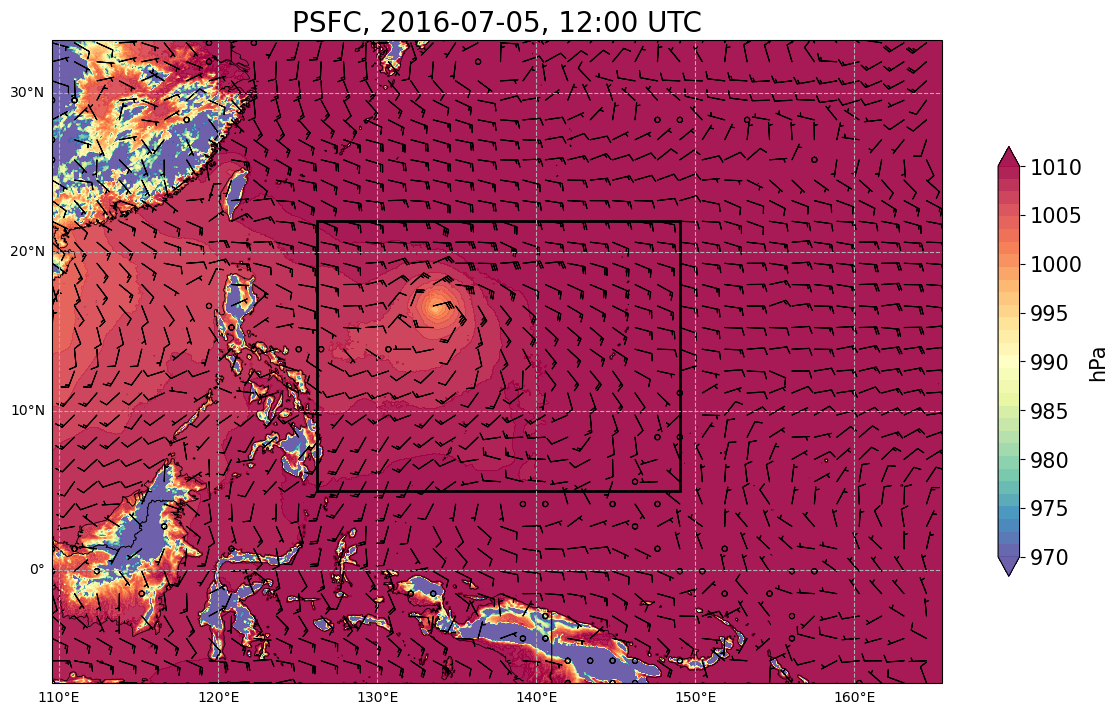

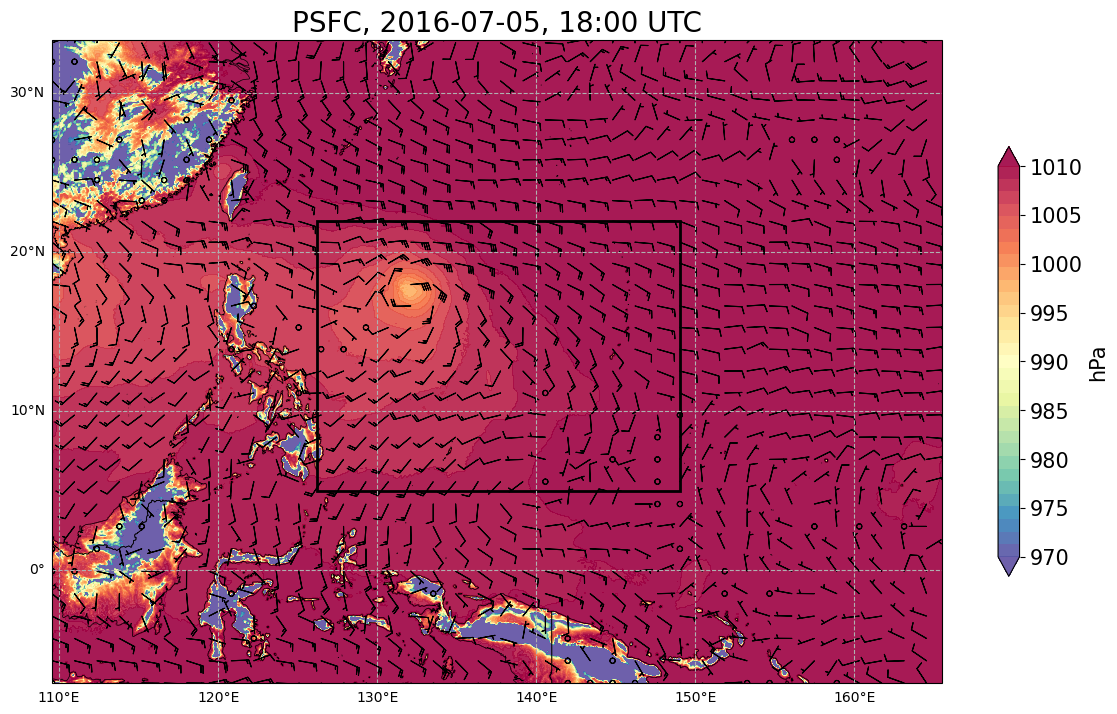

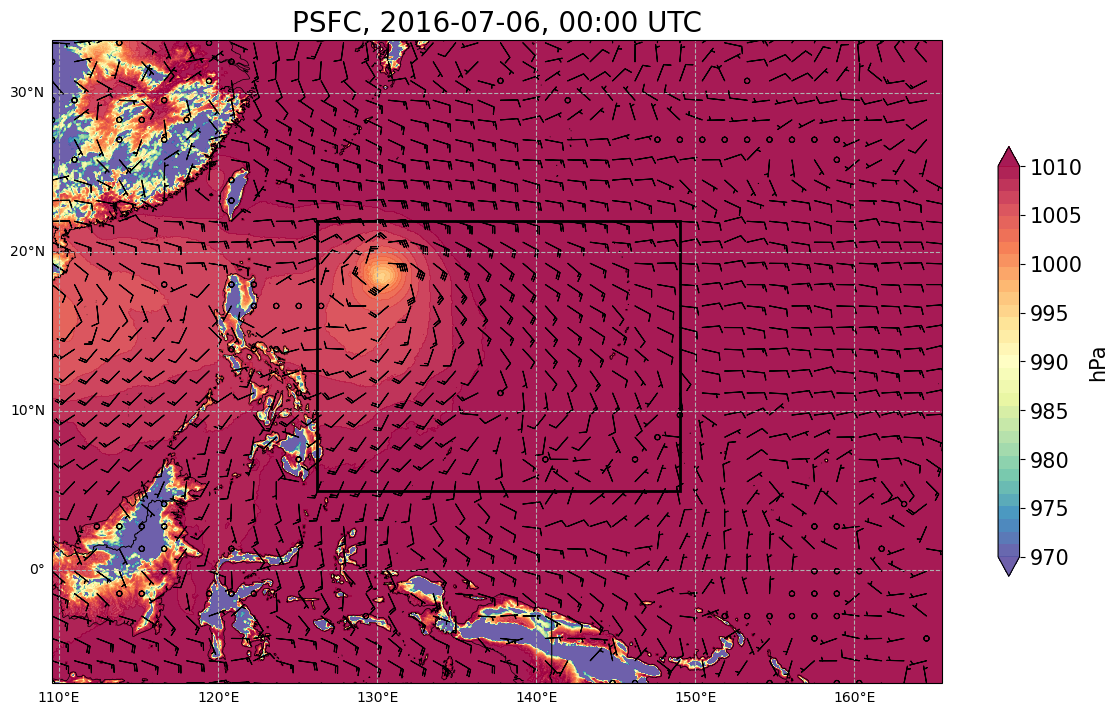

IndexError: list index out of range

In [32]:
# plt_area=[lon[0,0], lon[0,-1], lat[0,0], lat[-1,0]] # W,E,S,N

d02_bounds = np.array([126.23, 149.050, 4.9877, 21.935])

# for ifile in range(nfiles-2,nfiles-1):
for ifile in range(nfiles-1,nfiles):
# for ifile in range(1):
    # for it_read in range(0,npd,6):
    # for it_read in range(nt-1,nt):
    for it_read in range(0,nt,6):
    # for it_read in range(9,10):
        # for var_name in ["OLR", "MRef", "900-600Thick"]:
        # for var_name in ["U10"]:
        for var_name in ["PSFC"]:
            # print("Plotting ", var_name, " from ", wrffiles[ifile], " at ", it_read)
            run_plot(var_name, wrffiles[ifile], it_read, d02_bounds=d02_bounds)#, plt_area=plt_area)